## Setup and Configuration for Multi class Effnet

In [38]:
import os
import cv2
import json
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.models import efficientnet_b2

from sklearn.metrics import classification_report, multilabel_confusion_matrix

In [39]:
# Paths
root_path = os.path.join('..', 'dataset', 'malaria')
train_json_path = os.path.join(root_path, 'training.json')
test_json_path = os.path.join(root_path, 'test.json')
image_path = os.path.join(root_path, 'images')
models_dir = os.path.join('.', 'efficientnet_models')

os.makedirs(models_dir, exist_ok=True)

print("Root Path:", root_path)
print("Train JSON Path:", train_json_path)
print("Test JSON Path:", test_json_path)
print("Image Path:", image_path)

Root Path: ..\dataset\malaria
Train JSON Path: ..\dataset\malaria\training.json
Test JSON Path: ..\dataset\malaria\test.json
Image Path: ..\dataset\malaria\images


## Model and Dataset Definitions

In [40]:
class MalariaDataset(Dataset):
    """
        class for mapping images with bounding boxes
    """
    def __init__(self, json_path, image_root, transform=None, category_map=None):
        with open(json_path, 'r') as f:
            self.entries = json.load(f)
        self.image_root = image_root
        self.transform = transform

        if category_map is None:
            all_categories = set()
            for item in self.entries:
                for obj in item['objects']:
                    all_categories.add(obj['category'])
            self.category_map = {cat: idx for idx, cat in enumerate(sorted(list(all_categories)))}
        else:
            self.category_map = category_map
        
        self.labels = []
        for item in self.entries:
            if item['objects']:
                cat = item['objects'][0]['category']
                self.labels.append(self.category_map[cat])
            else:
                self.labels.append(-1)

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        entry = self.entries[idx]
        pathname_from_json = entry['image']['pathname']
        image_name = os.path.basename(pathname_from_json)
        image_full_path = os.path.join(self.image_root, image_name)

        try:
            image = Image.open(image_full_path).convert("RGB")
        except FileNotFoundError:
            print(f"Error: Image not found at {image_full_path}")
            return None # Will be filtered by collate_fn

        boxes = []
        labels = []
        for obj in entry['objects']:
            bb = obj['bounding_box']
            boxes.append([bb['minimum']['c'], bb['minimum']['r'], bb['maximum']['c'], bb['maximum']['r']])
            labels.append(self.category_map[obj['category']])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        if self.transform:
            image = self.transform(image)

        target = {'boxes': boxes, 'labels': labels}
        return image, target

### Model architecture

In [41]:
class EfficientNetDetector(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetDetector, self).__init__()
        # Loading pre-trained EfficientNet-B2 as the backbone
        self.backbone = efficientnet_b2(weights='IMAGENET1K_V1')
        
        # Replacing the final classifier with an identity layer
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()
        
        # classifier for multi-label classification
        self.classifier = nn.Linear(in_features, num_classes)

    def forward(self, x):
        # Pass input through the backbone
        features = self.backbone(x)
        
        # Getting class scores from the classifier
        class_scores = self.classifier(features)
        
        # return the class scores
        return class_scores

## Training and Validation Functions

In [42]:
def train_model(model, loader, optimizer, device, epoch, num_classes):
    model.train()
    running_loss, correct, total_objects = 0.0, 0, 0
    pbar = tqdm(loader, desc=f"Training Epoch {epoch}")
    
    # the loss function BCEWithLogitsLoss is ideal for multi-label tasks as it combines Sigmoid + BCE.
    # `pos_weight` forces the model to focus on rare classes by heavily penalizing mistakes on them.
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

    for images, targets_list in pbar:
        if not images.numel(): continue # Skip empty batches
        images = images.to(device)
        optimizer.zero_grad()
        
        # Getting the class scores
        class_scores = model(images)
        
        # Creating a placeholder for all target labels in the batch
        all_target_labels = torch.zeros_like(class_scores).to(device)

        # Populate the multi-hot encoded tensor
        for i, target in enumerate(targets_list):
            labels = target['labels']
            if len(labels) > 0:
                all_target_labels[i, labels] = 1.0

        # Calculate loss for the whole batch at once
        loss = criterion(class_scores, all_target_labels)

        if images.size(0) > 0:
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Apply sigmoid to get probabilities, then threshold to get predictions
        preds = torch.sigmoid(class_scores)
        preds[preds >= 0.5] = 1
        preds[preds < 0.5] = 0

        # Compare if the predicted multi-hot vector exactly matches the true one
        total_objects += images.size(0)
        correct += (preds == all_target_labels).all(dim=1).sum().item()

        pbar.set_postfix(loss=f"{loss.item():.4f}")

    epoch_loss = running_loss / len(loader) if len(loader) > 0 else 0
    accuracy = 100 * correct / total_objects if total_objects > 0 else 0
    return epoch_loss, accuracy

def validate_model(model, loader, device, num_classes, category_map, return_preds=False):
    model.eval()
    all_labels_for_report = []
    all_preds_for_report = []
    pbar = tqdm(loader, desc="Validating")

    # Invert map to get name from index
    idx_to_category = {v: k for k, v in category_map.items()}
    # Get the integer labels for non-parasite classes
    non_parasite_labels = {category_map[cat] for cat in ['red blood cell', 'leukocyte', 'difficult'] if cat in category_map}

    with torch.no_grad():
        for images, targets_list in pbar:
            if not images.numel(): continue
            images = images.to(device)
            
            # class_scores, _ = model(images)
            # --- TO THIS ---
            class_scores = model(images)

            # Get predictions by applying sigmoid and a 0.5 threshold
            preds = torch.sigmoid(class_scores)
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            all_preds_for_report.extend(preds.cpu().numpy())

            # Create the true multi-hot labels for the batch
            true_labels = torch.zeros_like(preds)
            for i, target in enumerate(targets_list):
                labels = target['labels']
                if len(labels) > 0:
                    true_labels[i, labels] = 1.0
            all_labels_for_report.extend(true_labels.cpu().numpy())

    if return_preds:
        return all_labels_for_report, all_preds_for_report
    else:
        # Return overall accuracy if not doing a detailed report
        accuracy = 100 * np.mean(np.array(all_labels_for_report) == np.array(all_preds_for_report))
        return accuracy

## Main Training Pipeline

In [43]:
# Custom collate_fn to filter out None values from the batch
def custom_collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    if not batch:
        return torch.tensor([]), []
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    images = torch.stack(images, dim=0)
    return images, targets

In [44]:
# --- 1. Define Hyperparameters for our single run ---
params = {
    'lr': 0.001,
    'optimizer': 'Adam',
    'batch_size': 32,
    'image_size': 224,
    'sampling': 'oversample'
}
NUM_EPOCHS = 1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- 2. Create Datasets and Category Map ---
transform = transforms.Compose([
    transforms.Resize((params['image_size'], params['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_ds = MalariaDataset(train_json_path, image_path, transform=transform)
category_map = train_ds.category_map
num_classes = len(category_map)
test_ds = MalariaDataset(test_json_path, image_path, transform=transform, category_map=category_map)

print(f"Found {num_classes} classes: {category_map}")



# Place this code before your training loop
print("Calculating class weights for the loss function...")

# Count the occurrences of each class (positives)
# We build a multi-hot matrix for the whole dataset
multi_hot_labels = np.zeros((len(train_ds), num_classes), dtype=float)
for i, entry in enumerate(train_ds.entries):
    for obj in entry['objects']:
        cat_idx = category_map.get(obj['category'])
        if cat_idx is not None:
            multi_hot_labels[i, cat_idx] = 1.0

# Sum over the dataset to get positive counts for each class
positive_counts = multi_hot_labels.sum(axis=0)

# --- NEW: Print the number of instances for each class ---
print("\n--- Class Instance Counts ---")
# Get class names sorted by their index to match the counts
class_names = [name for name, index in sorted(category_map.items(), key=lambda item: item[1])]
# Print each class and its count
for name, count in zip(class_names, positive_counts):
    print(f"  - {name:<15}: {int(count)} instances")
# --- END OF NEW CODE ---

# Calculate total number of samples
total_samples = len(train_ds)

# Calculate pos_weight for each class
# Add a small epsilon (1e-6) to avoid division by zero for classes that might not appear
pos_weight = (total_samples - positive_counts) / (positive_counts + 1e-6)

# Convert to a PyTorch tensor
pos_weight_tensor = torch.tensor(pos_weight, dtype=torch.float).to(DEVICE)

print(f"Calculated pos_weight: {pos_weight_tensor.cpu().numpy()}")

Using device: cpu
Found 7 classes: {'difficult': 0, 'gametocyte': 1, 'leukocyte': 2, 'red blood cell': 3, 'ring': 4, 'schizont': 5, 'trophozoite': 6}
Calculating class weights for the loss function...

--- Class Instance Counts ---
  - difficult      : 342 instances
  - gametocyte     : 136 instances
  - leukocyte      : 94 instances
  - red blood cell : 1208 instances
  - ring           : 244 instances
  - schizont       : 157 instances
  - trophozoite    : 596 instances
Calculated pos_weight: [ 2.5321636  7.882353  11.851064   0.         3.9508197  6.6942673
  1.0268457]


In [45]:
# --- 3. Create DataLoaders (with optional oversampling) ---
sampler = None
if params['sampling'] == 'oversample':
    print("Applying weighted random oversampling...")

    # Get counts for each class. `minlength` ensures the array has a slot for every class.
    # We also filter out the `-1` labels for images that have no objects.
    class_counts = np.bincount(
        [label for label in train_ds.labels if label != -1], 
        minlength=num_classes
    )
    
    # Add a small epsilon (1e-6) to the denominator to prevent division by zero.
    class_weights = 1. / (class_counts + 1e-6)
    
    # Create sample weights, giving a weight of 0 to images with no objects.
    sample_weights = np.array([class_weights[t] if t != -1 else 0 for t in train_ds.labels])
    sampler = WeightedRandomSampler(torch.from_numpy(sample_weights).double(), len(sample_weights))

train_loader = DataLoader(
    train_ds,
    batch_size=params['batch_size'],
    collate_fn=custom_collate_fn,
    shuffle=True
)

test_loader = DataLoader(
    test_ds, 
    batch_size=params['batch_size'], 
    shuffle=False, 
    collate_fn=custom_collate_fn
)


Applying weighted random oversampling...


In [46]:
# --- 4. Initialize Model and Optimizer ---
model = EfficientNetDetector(num_classes=num_classes).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])

# --- 5. Run Training Loop ---
best_val_accuracy = 0.0
history = {'train_loss': [], 'train_accuracy': [], 'val_accuracy': []}

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train_model(model, train_loader, optimizer, DEVICE, epoch, num_classes)
    val_acc = validate_model(model, test_loader, DEVICE, num_classes, category_map)
    
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)
    history['val_accuracy'].append(val_acc)
    
    print(f"Epoch {epoch} Summary: Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            print(f"New best model! Val Accuracy: {best_val_accuracy:.2f}%")

            # --- 5. Save the best model for this experiment ---
            model_filename = (f"multi_c_model_lr_{params['lr']}_optim_{params['optimizer']}_"
                              f"sampling_{params['sampling']}_size_{params['image_size']}.pth")
            save_path = os.path.join(models_dir, model_filename)

            torch.save({
                'model_state_dict': model.state_dict(),
                'best_val_accuracy': best_val_accuracy,
                'params': params
            }, save_path)
            print(f"Model saved to {save_path}")

print("\n--- Training Complete ---")

Validating: 100%|██████████| 4/4 [00:12<00:00,  3.18s/it]

Epoch 1 Summary: Train Acc: 5.13%, Val Acc: 58.21%
New best model! Val Accuracy: 58.21%
Model saved to .\efficientnet_models\multi_c_model_lr_0.001_optim_Adam_sampling_oversample_size_224.pth

--- Training Complete ---


##  Final Evaluation and Analysis With Model Loading

In [47]:
print("--- Starting Final Evaluation on Test Set ---")

# --- 1. Load the Best Model State ---
best_model_path = os.path.join(models_dir, 'best_model.pth')
eval_model = EfficientNetDetector(num_classes=num_classes).to(DEVICE)
# Now, checkpoint IS the state_dict, so we load it directly
state_dict = torch.load(best_model_path, map_location=DEVICE, weights_only=True)
eval_model.load_state_dict(state_dict)
print(f"Loaded best model from {best_model_path}")

# --- 2. Get Final Predictions ---
y_true, y_pred = validate_model(eval_model, test_loader, DEVICE, num_classes, category_map, return_preds=True)

# --- 3. Generate Reports ---
class_names = [name for name, index in sorted(category_map.items(), key=lambda item: item[1])]
labels_for_report = list(range(len(class_names)))

# Classification Report
print("\n--- Classification Report ---")
report = classification_report(
    y_true, 
    y_pred, 
    target_names=class_names,
    labels=labels_for_report,
    zero_division=0
)
print(report)

--- Starting Final Evaluation on Test Set ---
Loaded best model from .\efficientnet_models\best_model.pth


Validating: 100%|██████████| 4/4 [00:14<00:00,  3.64s/it]


--- Classification Report ---
                precision    recall  f1-score   support

     difficult       0.00      0.00      0.00         5
    gametocyte       0.00      0.00      0.00        11
     leukocyte       0.00      0.00      0.00         0
red blood cell       1.00      0.62      0.77       120
          ring       0.43      0.61      0.50        57
      schizont       0.00      0.00      0.00         9
   trophozoite       1.00      0.03      0.07        59

     micro avg       0.66      0.43      0.52       261
     macro avg       0.35      0.18      0.19       261
  weighted avg       0.78      0.43      0.48       261
   samples avg       0.53      0.43      0.46       261




--- Per-Class Confusion Matrices ---


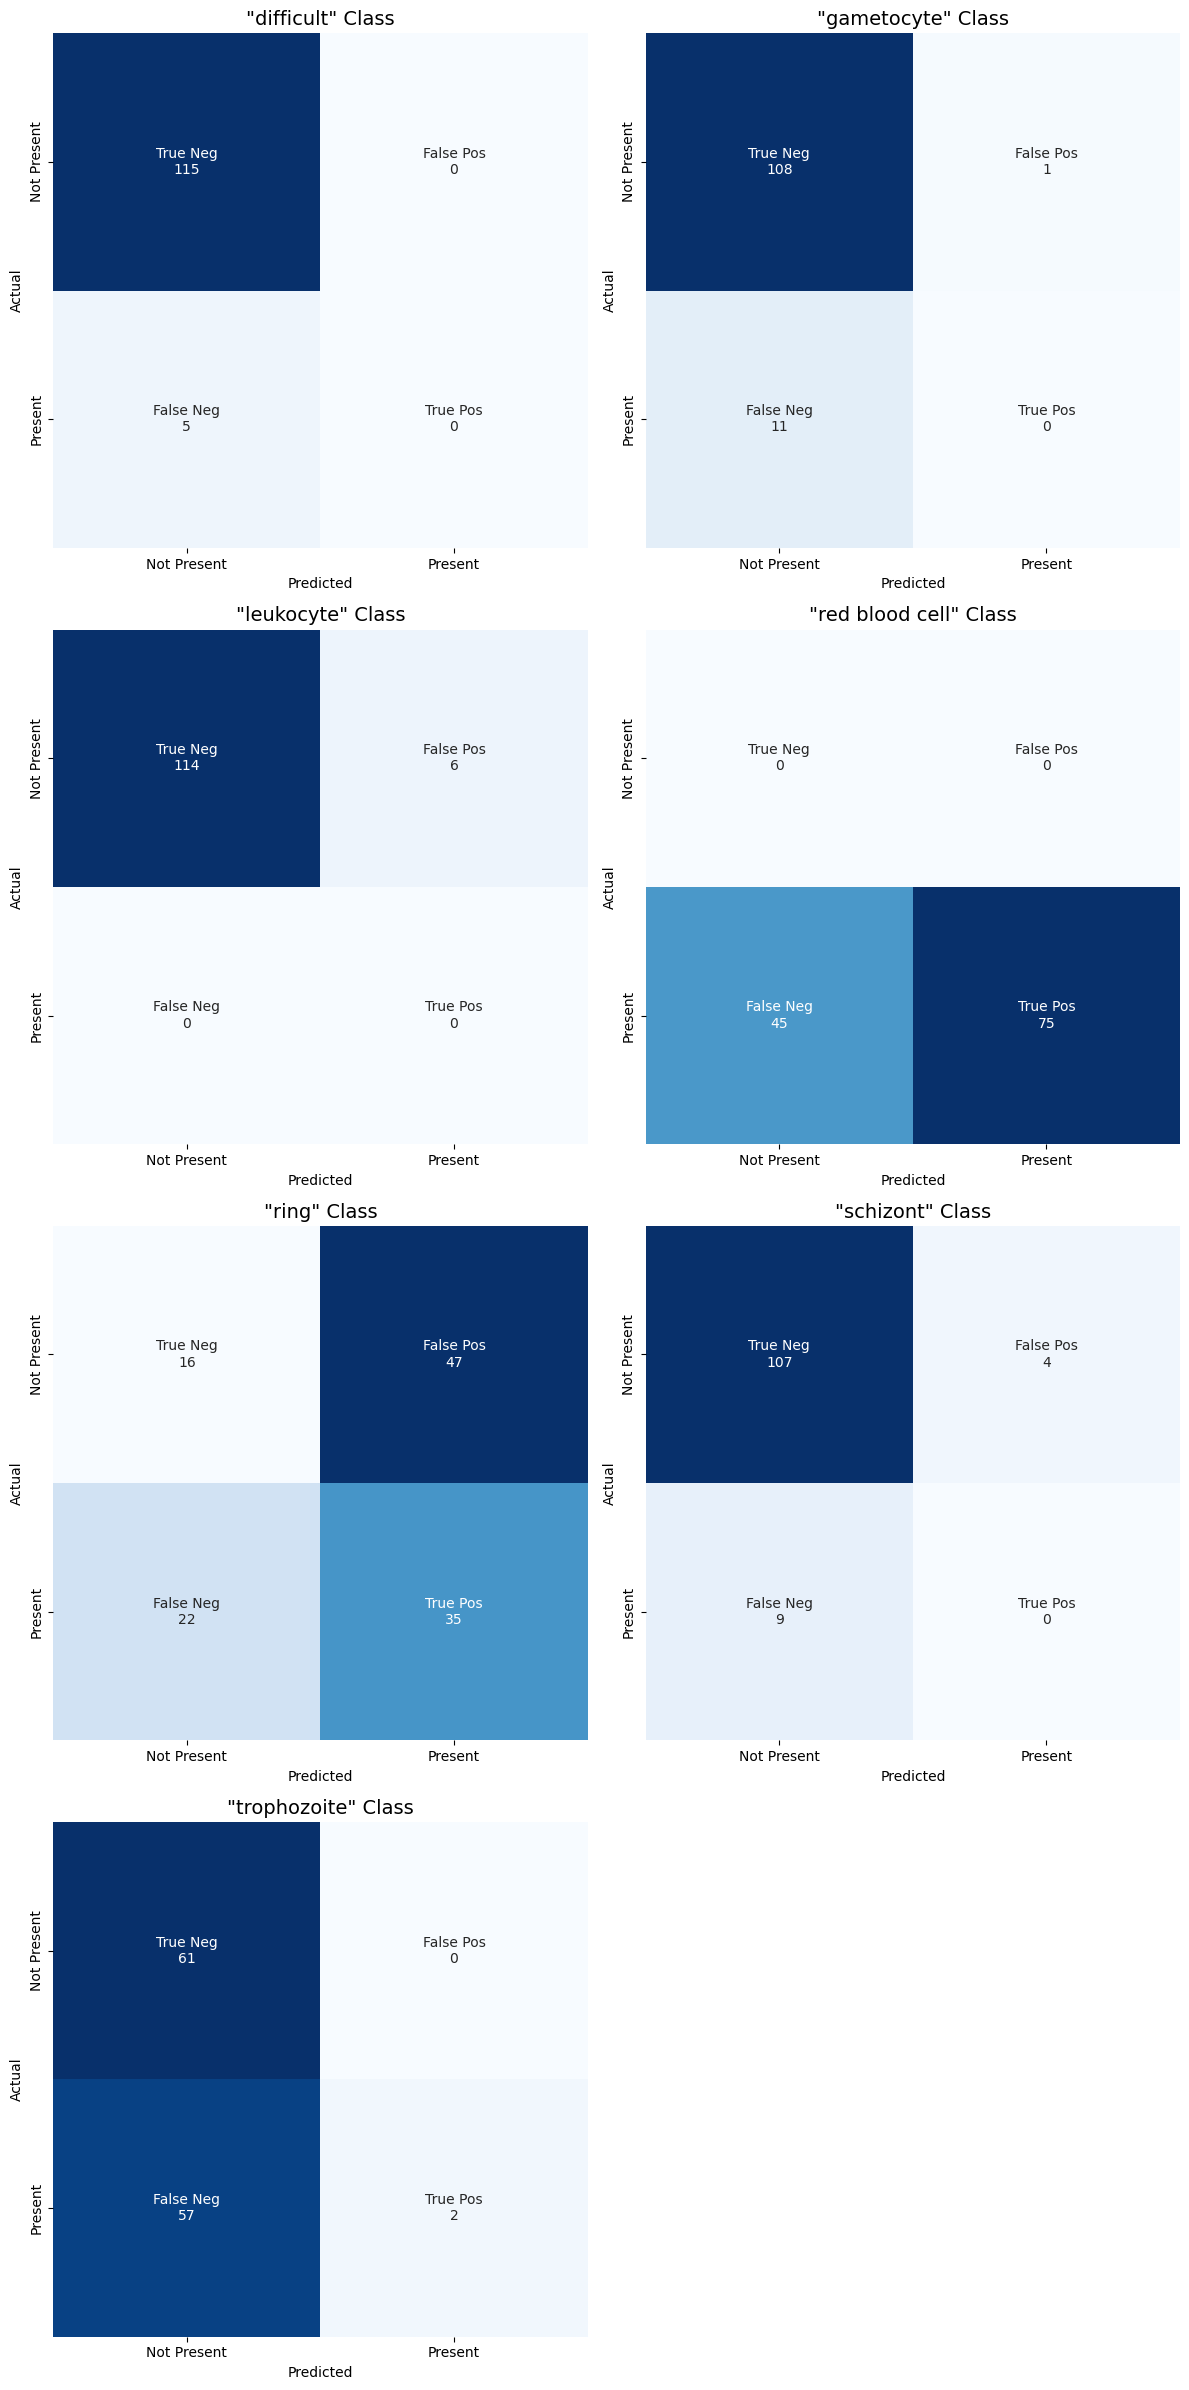

In [48]:
# --- 1. Generate the multi-label confusion matrices ---
mcm = multilabel_confusion_matrix(y_true, y_pred, labels=labels_for_report)

# --- 2. Plot a confusion matrix for each class ---
print("\n--- Per-Class Confusion Matrices ---")
# Create a subplot for each class
# Adjust nrows and ncols based on how many classes you have
nrows = (len(class_names) + 1) // 2
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(12, nrows * 6))
axes = axes.flatten() # Flatten the axes array for easy iteration

for i, class_name in enumerate(class_names):
    ax = axes[i]
    # Get the 2x2 matrix for the current class
    matrix = mcm[i]
    
    # Format the labels for the heatmap
    group_counts = [f"{value}" for value in matrix.flatten()]
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'"{class_name}" Class', fontsize=14)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_xticklabels(['Not Present', 'Present'])
    ax.set_yticklabels(['Not Present', 'Present'])

# Hide any unused subplots
for i in range(len(class_names), len(axes)):
    fig.delaxes(axes[i])
    
plt.tight_layout()
plt.show()

### Model prediction

In [49]:
# Create a single dictionary to hold all ground truth entries
all_entries_map = {}

# Populate the map from the training dataset
for entry in train_ds.entries:
    filename = os.path.basename(entry['image']['pathname'])
    all_entries_map[filename] = entry

# Add/overwrite with entries from the test dataset
for entry in test_ds.entries:
    filename = os.path.basename(entry['image']['pathname'])
    all_entries_map[filename] = entry

print(f"Created a lookup map with {len(all_entries_map)} total unique image entries.")

Created a lookup map with 1328 total unique image entries.


In [50]:
def visualize_diagnostic_prediction(
    model, image_path, all_entries_map, device, class_names, threshold=0.5
):
    """
    Performs a diagnostic prediction, providing an infection status and a
    clear comparison between predicted and actual classes.
    """
    # Define which classes indicate an infection
    parasite_classes = {'gametocyte', 'trophozoite', 'schizont', 'ring'}
    
    print(f"--- Processing image: {os.path.basename(image_path)} ---")
    image_pil = Image.open(image_path).convert("RGB")
    
    # --- 1. Get Ground Truth Data ---
    target_filename = os.path.basename(image_path)
    ground_truth_entry = all_entries_map.get(target_filename)
    ground_truth_labels = set()
    if ground_truth_entry and ground_truth_entry['objects']:
        ground_truth_labels = {obj['category'] for obj in ground_truth_entry['objects']}

    # --- 2. Preprocess and Predict ---
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = transform(image_pil).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        class_scores = model(image_tensor)

    # --- 3. Decode Predictions & Determine Status ---
    probabilities = torch.sigmoid(class_scores[0])
    predicted_indices = (probabilities >= threshold).nonzero(as_tuple=True)[0]
    predicted_labels = {class_names[i] for i in predicted_indices}
    
    print("\n--- Prediction Breakdown ---")
    all_scores = sorted([(class_names[i], probabilities[i].item()) for i in range(len(class_names))], key=lambda x: x[1], reverse=True)
    for class_name, score in all_scores:
        print(f"  - {class_name:<15}: {score*100:.2f}%")

    print("\n--- Ground Truth Breakdown ---")
    if ground_truth_entry and ground_truth_entry['objects']:
        gt_labels = [obj['category'] for obj in ground_truth_entry['objects']]
        frequency_counts = Counter(gt_labels)
        sorted_freq = sorted(frequency_counts.items(), key=lambda item: item[1], reverse=True)
        print("Class Frequencies:")
        for class_name, count in sorted_freq:
            print(f"  - {class_name:<15}: {count}")
    else:
        print("  - No ground truth objects listed for this image.")
    

    # Determine infection status
    predicted_status = "Infected" if not predicted_labels.isdisjoint(parasite_classes) else "Not Infected"
    actual_status = "Infected" if not ground_truth_labels.isdisjoint(parasite_classes) else "Not Infected"

    # --- 4. Print Detailed Breakdowns ---
    
    # Final Diagnosis (Infected/Not Infected)
    print("\n--- Final Diagnosis ---")
    diagnosis_correct = (predicted_status == actual_status)
    print(f"Model Diagnosis: {predicted_status} | Actual Status: {actual_status} {'✅' if diagnosis_correct else '❌'}")
    
    # Detailed Class-by-Class Comparison
    print("\n--- Prediction Summary ---")
    true_positives = predicted_labels.intersection(ground_truth_labels)
    false_positives = predicted_labels.difference(ground_truth_labels)
    false_negatives = ground_truth_labels.difference(predicted_labels)

    print(f"✅ Correctly Predicted: {', '.join(true_positives) if true_positives else 'None'}")
    print(f"❌ Missed: {', '.join(false_negatives) if false_negatives else 'None'}")
    print(f"⚠️ Incorrectly Predicted: {', '.join(false_positives) if false_positives else 'None'}")


    # --- 5. Create the side-by-side plot ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot 1: Model Prediction
    ax1.imshow(image_pil)
    ax1.set_title(f'Model Diagnosis: {predicted_status}', fontsize=16, color='green' if diagnosis_correct else 'red')
    ax1.axis('off')
    if predicted_labels:
        label_texts = [f"- {label}" for label in sorted(list(predicted_labels))]
        summary_text = "Predicted Classes:\n" + "\n".join(label_texts)
        ax1.text(0.02, 0.98, summary_text, transform=ax1.transAxes, fontsize=12,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='limegreen', alpha=0.7))
    else:
        ax1.text(0.5, 0.5, 'No classes predicted', color='white', fontsize=14, ha='center', va='center',
                 bbox=dict(facecolor='red', alpha=0.7, edgecolor='none'), transform=ax1.transAxes)

    # Plot 2: Ground Truth
    ax2.imshow(image_pil)
    ax2.set_title(f'Actual Status: {actual_status}', fontsize=16)
    ax2.axis('off')
    if ground_truth_entry and ground_truth_entry['objects']:
        for obj in ground_truth_entry['objects']:
            bb = obj['bounding_box']
            rect_gt = patches.Rectangle((bb['minimum']['c'], bb['minimum']['r']), 
                                        bb['maximum']['c'] - bb['minimum']['c'], 
                                        bb['maximum']['r'] - bb['minimum']['r'], 
                                        linewidth=3, edgecolor='gold', facecolor='none')
            ax2.add_patch(rect_gt)
            ax2.text(bb['minimum']['c'], bb['minimum']['r'] - 15, obj['category'], color='black', fontsize=12,
                     bbox=dict(facecolor='gold', alpha=0.8, edgecolor='none'))
    else:
        ax2.text(0.5, 0.5, 'No ground truth objects', color='white', fontsize=14, ha='center', va='center',
                 bbox=dict(facecolor='gray', alpha=0.7, edgecolor='none'), transform=ax2.transAxes)

    plt.tight_layout()
    plt.show()

--- Processing image: f91670db-be74-474c-bd72-68120aed4756.png ---

--- Prediction Breakdown ---
  - ring           : 70.25%
  - leukocyte      : 57.52%
  - difficult      : 49.77%
  - red blood cell : 43.58%
  - schizont       : 30.87%
  - trophozoite    : 19.18%
  - gametocyte     : 16.19%

--- Ground Truth Breakdown ---
Class Frequencies:
  - red blood cell : 56
  - ring           : 2

--- Final Diagnosis ---
Model Diagnosis: Infected | Actual Status: Infected ✅

--- Prediction Summary ---
✅ Correctly Predicted: ring
❌ Missed: red blood cell
⚠️ Incorrectly Predicted: leukocyte


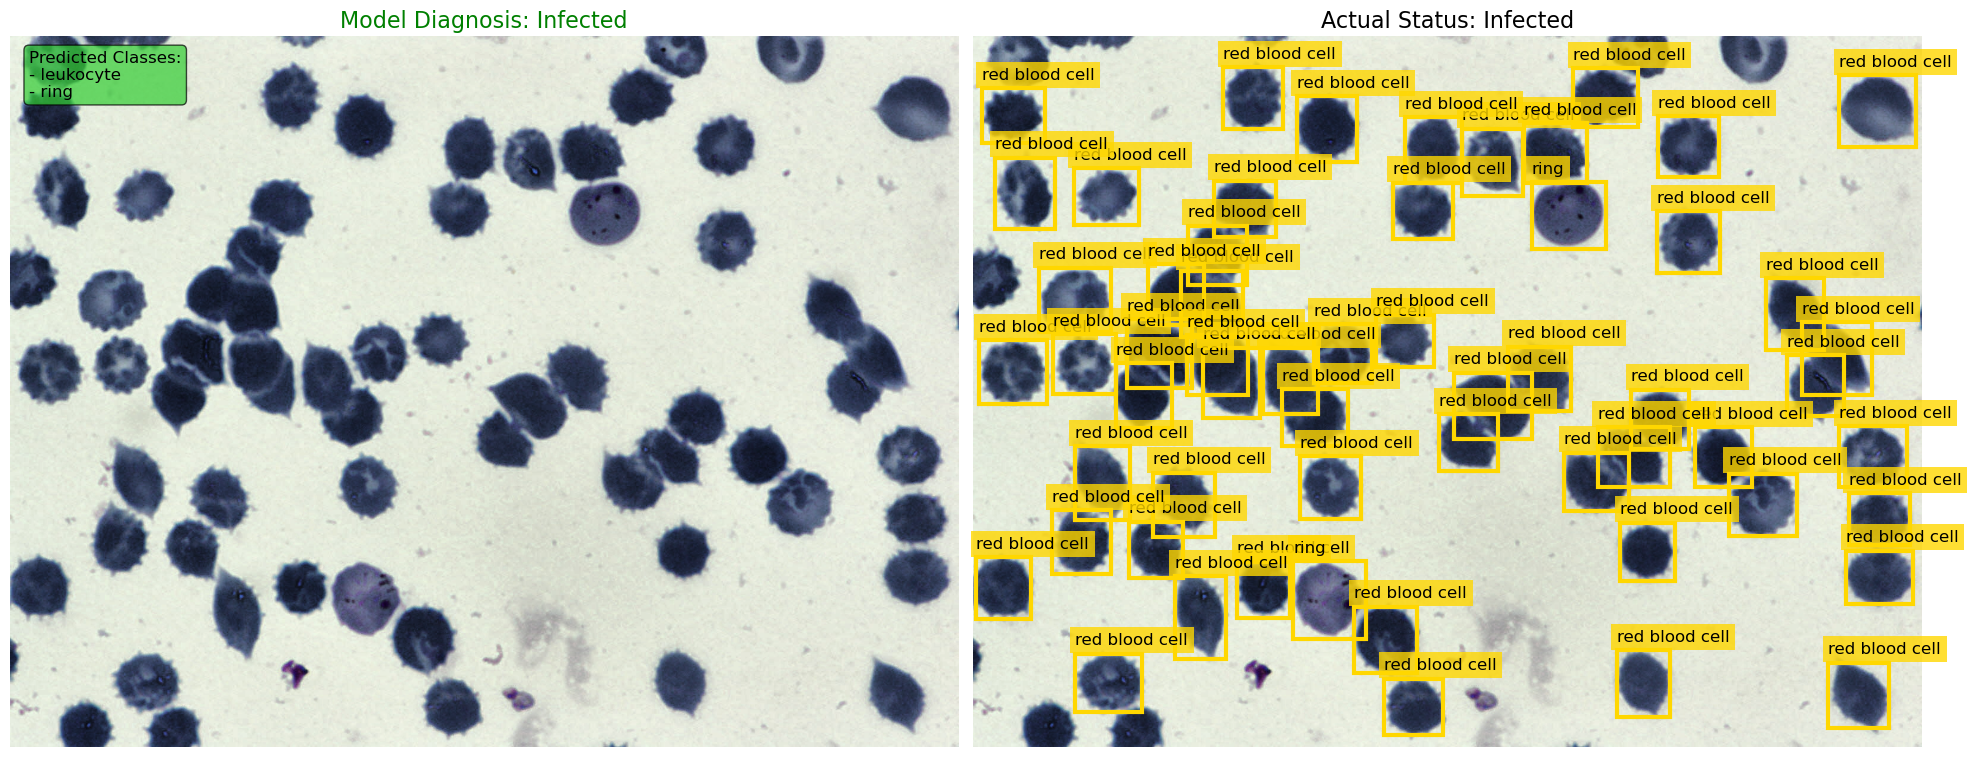

In [51]:
# The function call is the same
my_image_path = os.path.join(image_path, 'f91670db-be74-474c-bd72-68120aed4756.png')

visualize_diagnostic_prediction(
    model=eval_model,
    image_path=my_image_path,
    all_entries_map=all_entries_map,
    device=DEVICE,
    class_names=class_names,
    threshold=0.5 # You can adjust this threshold
)

## Gradcam

In [52]:
class GradCAM:
    """
    A robust Grad-CAM class that properly manages and removes hooks.
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Store hook handles to be able to remove them later
        self.handles = []
        self._register_hooks()

    def _capture_activations(self, module, input, output):
        self.activations = output.detach()

    def _capture_gradients(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def _register_hooks(self):
        # Register hooks and store their handles
        handle_forward = self.target_layer.register_forward_hook(self._capture_activations)
        handle_backward = self.target_layer.register_full_backward_hook(self._capture_gradients)
        self.handles.extend([handle_forward, handle_backward])

    def remove_hooks(self):
        # Use the stored handles to remove the hooks
        for handle in self.handles:
            handle.remove()

    def generate_heatmap(self, model_output, class_idx):
        if class_idx is None:
            class_idx = model_output.argmax(dim=1)
        
        self.model.zero_grad()
        model_output[0, class_idx].backward(retain_graph=True)
        
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        
        for i in range(self.activations.shape[1]):
            self.activations[:, i, :, :] *= pooled_gradients[i]
            
        heatmap = torch.mean(self.activations, dim=1).squeeze().cpu()
        heatmap = F.relu(heatmap)
        heatmap /= (torch.max(heatmap) + 1e-8)
        
        return heatmap.numpy()

In [53]:
def visualize_with_gradcam(
    model, image_path, device, class_names, threshold=0.5
):
    """
    Makes a prediction and visualizes the result with a Grad-CAM heatmap,
    ensuring hooks are always removed.
    """
    # --- Set up Grad-CAM and ensure cleanup ---
    target_layer = model.backbone.features[-1]
    grad_cam = GradCAM(model, target_layer)
    
    try:
        # --- All the visualization logic goes inside the 'try' block ---
        print(f"--- Processing image: {os.path.basename(image_path)} ---")
        image_pil = Image.open(image_path).convert("RGB")
        
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        image_tensor = transform(image_pil).unsqueeze(0).to(device)

        model.eval()
        class_scores = model(image_tensor)
        probabilities = torch.sigmoid(class_scores[0])
        
        all_scores = sorted(
            [(class_names[i], prob.item()) for i, prob in enumerate(probabilities)],
            key=lambda x: x[1],
            reverse=True
        )

        print("\n--- Prediction Breakdown ---")
        for class_name, score in all_scores:
            print(f"  - {class_name:<15}: {score*100:.2f}%")
            
        top_class_idx = probabilities.argmax().item()
        top_class_name = class_names[top_class_idx]
        
        print(f"\nGenerating Grad-CAM for the top prediction: '{top_class_name}'")

        heatmap = grad_cam.generate_heatmap(class_scores, class_idx=top_class_idx)
        
        heatmap_resized = cv2.resize(heatmap, (image_pil.width, image_pil.height))
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

        image_np = np.array(image_pil)
        superimposed_img = cv2.addWeighted(image_np, 0.6, heatmap_colored, 0.4, 0)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        
        ax1.imshow(image_pil)
        ax1.set_title("Original Image")
        ax1.axis('off')
        
        ax2.imshow(superimposed_img)
        confidence = probabilities[top_class_idx].item() * 100
        ax2.set_title(f"Grad-CAM: Predicted '{top_class_name}' ({confidence:.2f}%)")
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()

    finally:
        # --- This line will run no matter what, cleaning up the hooks ---
        grad_cam.remove_hooks()
        print("--- Grad-CAM hooks removed. ---")

--- Processing image: f91670db-be74-474c-bd72-68120aed4756.png ---

--- Prediction Breakdown ---
  - ring           : 70.25%
  - leukocyte      : 57.52%
  - difficult      : 49.77%
  - red blood cell : 43.58%
  - schizont       : 30.87%
  - trophozoite    : 19.18%
  - gametocyte     : 16.19%

Generating Grad-CAM for the top prediction: 'ring'


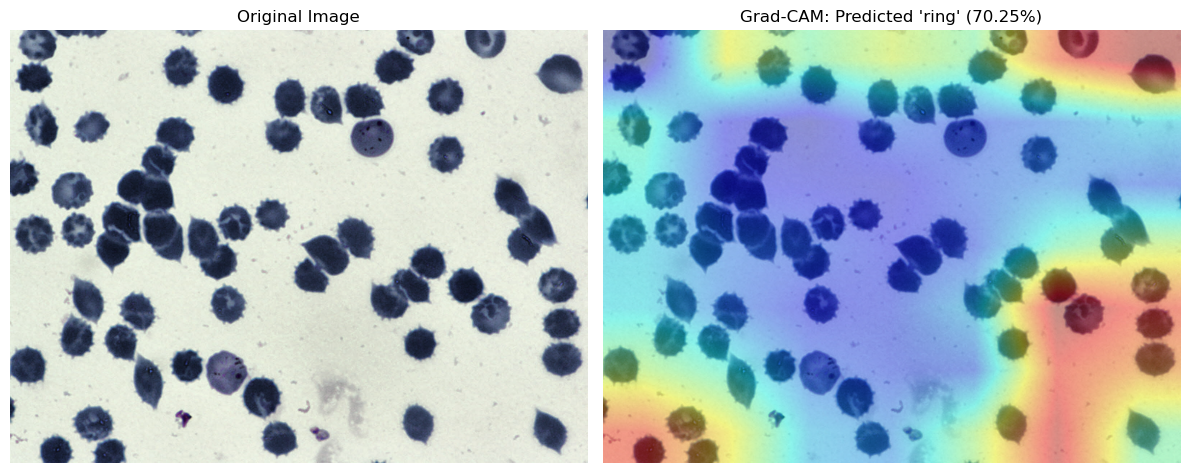

--- Grad-CAM hooks removed. ---


In [54]:
# Specify the path to an image you want to test
my_image_path = os.path.join(image_path, 'f91670db-be74-474c-bd72-68120aed4756.png')

# Call the new visualization function
visualize_with_gradcam(
    model=eval_model, 
    image_path=my_image_path,
    device=DEVICE,
    class_names=class_names
)